In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

import graph_tool.all as gt
# import networkx as nx


from hoi.metrics import Oinfo, TC, DTC, Sinfo, GradientOinfo
from hoi.utils import get_nbest_mult
from hoi.metrics import InfoTopo
from hoi.plot import plot_landscape

# since we are dealing with larger matrices here, we use thoi mostly
from thoi.measures.gaussian_copula import multi_order_measures, nplets_measures
from thoi.heuristics import simulated_annealing, greedy

In [ ]:
def network_energy(corrmat: np.ndarray, cuberootQ: bool = False) -> float:
    """
    Compute the network energy-balance U from a correlation matrix.

    ---
    Notes:
    code adapted from: https://github.com/majidsaberi/NetEnergyCogControl/blob/main/NetworkEnergy.R
    Originally written in R by Majid Saberi, March, 2024
    
    in this version, you can choose whther using the cuberoot, such as in Saberi et al (2024) or without, such as in Marvel and Strogatz (2009)
    Adapted to Python by Enrico Caprioglio, July, 2025
    """

    if corrmat.ndim != 2 or corrmat.shape[0] != corrmat.shape[1]:
        raise ValueError("corrmat must be a square 2-D array")

    n = corrmat.shape[0]
    if n < 3:
        raise ValueError("At least three nodes are required (matrix must be 3×3 or larger)")

    total_energy = 0.0
    triplet_count = 0

    # iterate over unordered triplets (i < j < k)
    for i in range(n - 2):
        for j in range(i + 1, n - 1):
            for k in range(j + 1, n):
                prod = corrmat[i, j] * corrmat[i, k] * corrmat[k, j]
                
                if cuberootQ == False:
                    # Marvel and Strogatz (2009) – no cube root
                    triplet_energy = np.sign(prod) * abs(prod)
                else:
                    # cube-root variant (such as Saberi et al (2024))
                    triplet_energy = np.sign(prod) * np.cbrt(abs(prod))

                total_energy += triplet_energy
                triplet_count += 1

    return -total_energy / triplet_count

In [3]:
plt.style.use('seaborn-v0_8-whitegrid')

# Brain functional connectivity study

Data is publicly avalable from (clickable link):
- Rieck et al (2021) [Dataset of functional connectivity during cognitive control for an adult lifespan sample](https://doi.org/10.1016/j.dib.2021.107573)

In [5]:
def collect_data_from_FC(filename, order, repeat=10, method='greedy', verbose=True):

    if verbose:
        print("Running   :", method.capitalize())
        print("Filename      :", filename)
        print("n‒plet order  :", order)
        print("No. of repeats  :", repeat)

    # not the most robust way to do this ... these are the files I have
    if filename[-3:] == 'npy':
        corrmat = np.load(filename)
    if filename[-3:] == 'txt':
        corrmat = np.loadtxt(filename)

    if method=='greedy':

        # ---- Greedy algorithm ---- #
        syn_nplets, syn_O_data = greedy(
            corrmat, 3, order, covmat_precomputed=True, repeat=repeat, metric='o'
            )
        red_nplets, red_O_data = greedy(
            corrmat, 3, order, covmat_precomputed=True, repeat=repeat, largest=True, metric='o'
            )
        
        # note if using greedy:
        # the last column selects the O-info of the nplet of order=order
        # the first colum is instead the starting O-info used in the algorithm
        O_syn = syn_O_data[:, order-3]
        O_red = red_O_data[:, order-3]

        return syn_nplets, O_syn, red_nplets, O_red
    
    if method=='annealing':

        # ---- Simulated Annealing ---- #
        syn_nplets, O_syn = simulated_annealing(
            corrmat, order=order, covmat_precomputed=True, repeat=repeat, early_stop=10000
            )
        red_nplets, O_red = simulated_annealing(
            corrmat, order=order, covmat_precomputed=True, repeat=repeat, early_stop=10000, largest=True
            )
        
        return syn_nplets, O_syn, red_nplets, O_red

In [7]:
def collect_U(filename, nplets, cuberootQ=False):

    # not the most robust way to do this ... these are the files I have
    if filename[-3:] == 'npy':
        corrmat = np.load(filename)
    if filename[-3:] == 'txt':
        corrmat = np.loadtxt(filename)
    U_data = []

    for (idx, nplet) in enumerate(nplets):
        U = network_energy(corrmat[np.ix_(nplet, nplet)], cuberootQ=cuberootQ)
        U_data.append(U)

    return U_data

Running   : Greedy
Filename      : /Users/ec627/Documents/Data/fMRI_data_powers_cognitive_tasks/power229_with_rest/Power229_10_sub-001_rest.txt
n‒plet order  : 4
No. of repeats  : 100


Order:   0%|          | 0/1 [00:00<?, ?it/s]        

Order:   0%|          | 0/1 [00:00<?, ?it/s]        



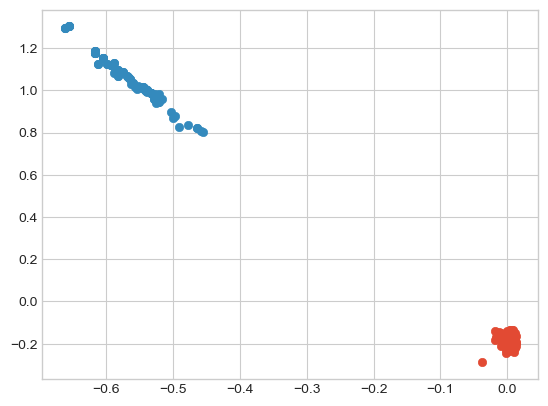

In [ ]:
filename = '/Users/ec627/Documents/Data/fMRI_data_powers_cognitive_tasks/power229_with_rest/Power229_10_sub-001_rest.txt'

# orders studied in the paper: [3, 5, 7, 10]
order = 4

# to collect same data as in figure 4 in the main text, use repeat=10000
syn_nplets, O_syn, red_nplets, O_red = collect_data_from_FC(
    filename, order, repeat=100, method='greedy', verbose=True
    )

U_syn = collect_U(filename, syn_nplets, cuberootQ=False)
U_red = collect_U(filename, red_nplets, cuberootQ=False)

plt.scatter(U_syn, O_syn, label='top Synergistic', marker='o')
plt.scatter(U_red, O_red, label='Top redundant', marker='o')

In [12]:
folderpath='/Users/ec627/Documents/Data/fMRI_data_powers_cognitive_tasks/thoi_data_analysis/individuals_greedy/'

# NOTE: manually change these
individualID=1
method='greedy'
repeat=10000

filename = f'individual_{individualID}_method_{method}_repeats_{repeat}_order_{order}.npy'

res = {
    "U_syn": U_syn, "O_syn": O_syn.numpy(),
    "U_red": U_red, "O_red": O_red.numpy(),
    "syn_nplets": syn_nplets.numpy(), "red_nplets": red_nplets.numpy(),
    "order": order, "individualID": individualID
    }

# np.save(folderpath+filename, res)
print('file saved at ', folderpath+filename)

file saved at  /Users/ec627/Documents/Data/fMRI_data_powers_cognitive_tasks/thoi_data_analysis/individuals_greedy/individual_1_method_greedy_repeats_10000_order_4.npy
